## Sequence to Sequence Models for Convertational Agents

Implementation of encoder decoder architechtures in Python3 with Pytorch

### Reading the data
Dataset MetaLWoz: 

In [1]:
import json
import string

In [2]:
### Maximum and Minimum Sentence length
MIN_LENGTH = 3
MAX_LENGTH = 13

In [3]:
### Utility for flattening iterables
FLATTEN = lambda l: [i for e in l for i in e]

In [4]:
### JSON Parse and prepend greeting
def read_file(filename):
    return [['Hi Mr Robot'] + json.loads(line)['turns'] for line in open(filename, 'r')]

In [5]:
### Data is ordered in dialogues creates pairs from a single dialogue
def create_pairs_from_dialogue(dialogue):
    return [(dialogue[2 * i], dialogue[2 * i + 1]) for i in range(len(dialogue) // 2)]

In [6]:
### Wrapper to previous function to create all pairs
def create_pairs(dialogues):
    return FLATTEN(map(create_pairs_from_dialogue, dialogues))

In [7]:
### Apply length constraints
def filter_pairs(pairs):
    length_constraints = lambda s: MIN_LENGTH <= len(s.split()) <= MAX_LENGTH
    filter_pair = lambda p: all(length_constraints(s) for s in p)
    return [*filter(filter_pair, pairs)]

In [8]:
### Remove punctuation and convert to lowercase
def normalize_sentence(sentence):
    return sentence.translate({ord(i): None for i in string.punctuation}).lower()

### Wrapper for normalize_sentence
def normalize_pairs(pairs):
    return [*map(lambda p: tuple(map(normalize_sentence, p)), pairs)]

In [9]:
### Create a dictionary of all unique words and SOS and EOS tokens
def create_dictionary(pairs):
    all_words = FLATTEN([q.split() + a.split() for q, a in pairs])
    unique_words = set(all_words)
    dictionary = {key: value + 2 for value, key in enumerate(unique_words)}
    return {**{'SOS': 0, 'EOS': 1}, **dictionary}

In [10]:
### Encodes sentence from dictionary
def encode_sentence(s, dictionary):
    return [dictionary[word] for word in s.split()]

### Wrapper for encode_sentence
def encode_pairs(pairs, dictionary):
    return [*map(lambda p: tuple(map(lambda s: encode_sentence(s, dictionary), p)), pairs)]

In [11]:
def process_pairs(filename):
    dialogues = read_file(filename)
    pairs = create_pairs(dialogues)
    filtered_pairs = filter_pairs(pairs)
    normalized_pairs = normalize_pairs(filtered_pairs)
    return normalized_pairs

def create_dictionary_encode(pairs):
    dictionary = create_dictionary(pairs)
    encoded_pairs = encode_pairs(pairs, dictionary)
    append_EOS = lambda p: (p[0], p[1] + [1])
    return [*map(append_EOS, encoded_pairs)], dictionary
    

In [12]:
### Helper Function
def reverse_dictionary(dictionary):
    return {value: key for key, value in dictionary.items()}

def decode_sentence(s, dictionary):
    return [dictionary[w] for w in s]

### Building Encoders and Decoders


In [13]:
import torch

This encoder architechture includes an embedding layer to tranform words to a constant size vector. Otherwise, we would have to process words an one hot vectors of size equal to the size of the vocabulary which would be sparse and challenging to learn from.

Documentation for layer used here: https://pytorch.org/docs/stable/nn.html

In [14]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        self.gru = torch.nn.GRU(hidden_size, hidden_size)
    
    def forward(self, x, s):
        embedded = self.embedding(x)
        return self.gru(embedded, s)
    
    def __init_hidden__(self, hidden_size): return torch.zeros(1, hidden_size)

The decoder has a similar architechture to the encoder but since output do matter in this case we map the hidden state to a vector of size equal to the vocabulary size with a linear layer which would give us a word at each decoding time step

In [15]:
class Decoder(torch.nn.Module):
    def __init__(self, output_size, hidden_size):
        super(Decoder, self).__init__()
        self.embedding = torch.nn.Embedding(output_size, hidden_size)
        self.gru = torch.nn.GRU(hidden_size, hidden_size)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim = 2)
    
    def forward(self, x, s):
        embedded = self.embedding(x)
        _ , hidden_state = self.gru(embedded, s)
        output = self.fc(hidden_state)
        return self.softmax(output), hidden_state

### Training
Two approaches to training. The first one is the slower but more easy to conceptualize than the second so we will start with the former.

In [16]:
HIDDEN_SIZE = 512
LEARNING_RATE = 0.01
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
### Recursivelly propagate encoder
def propagate_encoder(encoder, question, state):
    try: encoder_input = next(question).view(1, 1)
    except StopIteration: return state
    _ , encoder_state = encoder(encoder_input, state)
    return propagate_encoder(encoder, question, encoder_state)

#### Encoder Demonstration
Initialize encoder create an iterable from the question initialize state and propagate to get final encoder state

In [25]:
def test_encoder():
    unencoded_pairs = process_pairs('data/dialogues/AGREEMENT_BOT.txt')
    pairs, dictionary = create_dictionary_encode(unencoded_pairs)
    encoder = Encoder(dictionary.__len__(), HIDDEN_SIZE)
    question = iter(torch.tensor(pairs[0][0], dtype = torch.long))
    initial_hidden_state = encoder.__init_hidden__(HIDDEN_SIZE).repeat(1, 1, 1)
    encoding = propagate_encoder(encoder, question, initial_hidden_state)
    assert encoding.shape == (1, 1, 512)
    return encoding

In [26]:
encoding = test_encoder()

In [22]:
### Propagate Decoder to get loss
def propagate_decoder(decoder, answer, decoder_input, decoder_state, loss_function, loss = 0):
    try: target = next(answer).view(1)
    except StopIteration: return loss
    decoder_prediction, state = decoder(decoder_input, decoder_state)
    sample_loss = loss_function(decoder_prediction.squeeze(0), target)
    output = torch.argmax(decoder_prediction, dim = 2).detach()
    if output.item() == 1: return loss
    return propagate_decoder(decoder, answer, output, state, loss_function, loss + sample_loss)

In [28]:
def test_decoder(encoding):
    unencoded_pairs = process_pairs('data/dialogues/AGREEMENT_BOT.txt')
    pairs, dictionary = create_dictionary_encode(unencoded_pairs)
    decoder = Decoder(dictionary.__len__(), HIDDEN_SIZE)
    answer = iter(torch.tensor(pairs[0][1], dtype = torch.long))
    initial_decoder_token = torch.tensor([[0]])
    loss_function = torch.nn.NLLLoss()
    loss = propagate_decoder(decoder, answer, initial_decoder_token, encoding, loss_function)
    try: loss.backward()
    except: print('Failure')

In [29]:
test_decoder(encoding)

#### Training Update

In [30]:
def train_update(loss, encoder_optimizer, decoder_optimizer):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss.backward()
    encoder_optimizer.step() 
    decoder_optimizer.step()

In [31]:
def single_training_pass(encoder, decoder, pairs, criterion, encoder_optim , decoder_optim):
    iteration_loss = 0
    for (question, answer) in pairs:
        question = iter(torch.tensor(question, dtype = torch.long, device = DEVICE)) 
        initial_hidden_state = encoder.__init_hidden__(HIDDEN_SIZE).repeat(1, 1, 1).to(DEVICE)
        encoding = propagate_encoder(encoder, question, initial_hidden_state)
        answer = iter(torch.tensor(answer, dtype = torch.long, device = DEVICE))
        initial_decoder_token = torch.tensor([[0]], device = DEVICE)
        loss = propagate_decoder(decoder, answer, initial_decoder_token, encoding, criterion)
        if loss != 0: train_update(loss, encoder_optim, decoder_optim)
        iteration_loss += loss.item()
    return iteration_loss

In [36]:
def train_test(iterations):
    unencoded_pairs = process_pairs('data/dialogues/AGREEMENT_BOT.txt')
    pairs, dictionary = create_dictionary_encode(unencoded_pairs)
    loss_function = torch.nn.NLLLoss()
    encoder = Encoder(dictionary.__len__(), HIDDEN_SIZE)
    decoder = Decoder(dictionary.__len__(), HIDDEN_SIZE)
    encoder = encoder.to(DEVICE)
    decoder = decoder.to(DEVICE)
    encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr = LEARNING_RATE)
    decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr = LEARNING_RATE)
    optimizers = (encoder_optimizer, decoder_optimizer)
    for iteration in range(iterations):
        loss = single_training_pass(encoder, decoder, pairs, loss_function, *optimizers)
        print(f'Iteration: {iteration}. Loss: {loss}')
    return encoder, decoder

In [37]:
train_test(1)

Iteration: 0. Loss: 22486.699201107025


(Encoder(
   (embedding): Embedding(1906, 512)
   (gru): GRU(512, 512)
 ), Decoder(
   (embedding): Embedding(1906, 512)
   (gru): GRU(512, 512)
   (fc): Linear(in_features=512, out_features=1906, bias=True)
   (softmax): LogSoftmax()
 ))

In [38]:
def save_models(encoder, decoder, encoder_filename, decoder_filename):
    torch.save(encoder.state_dict(), encoder_filename)
    torch.save(decoder.state_dict(), decoder_filename)

In [39]:
def evaluation_loop(encoder, decoder, dictionary):
    rev = reverse_dictionary(dictionary)
    while True:
        question = normalize_sentence(input('Q:'))
        try: encoded_question = encode_sentence(question, dictionary)
        except: 
            print('I have not seen one of these words before')
            continue
        query = iter(torch.tensor(encoded_question, dtype = torch.long))
        encoder_state = encoder.__init_hidden__(HIDDEN_SIZE).repeat(1, 1, 1)
        encoding = propagate_encoder(encoder, query, encoder_state)
        decoder_input = torch.tensor([[0]])
        decoder_state = encoding
        final_decoding = []
        while decoder_input.item() != 1:
            decoder_output, decoder_state = decoder(decoder_input, decoder_state)
            decoder_input = torch.argmax(decoder_output, dim = 2)
            final_decoding += [decoder_input.item()]
        print(decode_sentence(final_decoding, rev))

#### Parallel Training
This process is very slow and realizing how to parallelize this process in crucial. This is the tutorial from pytorch for sequence to sequence models https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html and offers no parallelization. Most importantly propagation though the encoder and decoder are done manually. If we refer back to the docs we can see than torch.nn.gru can take a whole sequence and automatically propagates state. Therefore propagate_encoder(encoder, question, initial_state) is equivelant to encoder(question, initial_state). Same applies to the decoder. Further we have been using a batch size of one which does not allow for almost any paralelization. It is impossible to parallelize pairs with different dimensions but we can do it ones with the same ones.

In [40]:
pair_dimensions = lambda q, a: (len(q), len(a))
def get_parallel_pairs(pairs):
    dimension_range = range(MIN_LENGTH, MAX_LENGTH + 1)
    for dimension in [(ql, al) for ql in dimension_range for al in dimension_range]:
        yield [*filter(lambda p: pair_dimensions(*p) == dimension, pairs)]

This function is the key to this approach. It takes any dimensions which the pair could take and returns all pairs with exactly that dimension. We need to rewrite the functions which propagate encoder and decoder

In [41]:
transpose = lambda t: torch.transpose(t, 0, 1)

def propagate_encoder(encoder, questions, sequence_size):
    questions = transpose(torch.tensor(questions, dtype = torch.long))
    initial_encoder_state = encoder.__init_hidden__(HIDDEN_SIZE).repeat(1, sequence_size, 1)
    return encoder(questions, initial_encoder_state)

def propagate_decoder(decoder, answers, decoder_input, decoder_state, loss_function, loss = 0):
    try: target = next(answers)
    except StopIteration: return loss
    decoder_predictions, state = decoder(decoder_input, decoder_state)
    sample_loss = loss_function(decoder_predictions.squeeze(0), target)
    output = torch.argmax(decoder_predictions, dim = 2).detach()
    return propagate_decoder(decoder, answers, output, state, loss_function, loss + sample_loss)

In [47]:
def parallel_training(encoder, decoder, pairs, encoder_optim, decoder_optim, loss_function):
    iteration_loss = 0
    for parallel_pairs in get_parallel_pairs(pairs):
        if parallel_pairs == []: continue
        sequence_size = len(parallel_pairs)
        questions, answers = tuple(map(list, zip(*parallel_pairs)))
        encoder_outputs, encoder_state = propagate_encoder(encoder, questions, sequence_size)
        decoder_input_tokens = torch.tensor([[0]], dtype = torch.long).repeat(1, sequence_size)
        decoder_answers = iter(transpose(torch.tensor(answers, dtype = torch.long)))
        decoder_args = decoder, decoder_answers, decoder_input_tokens, encoder_state 
        loss = propagate_decoder(*decoder_args, loss_function)
        train_update(loss, encoder_optim, decoder_optim)
        iteration_loss += loss.item()
    return iteration_loss

In [50]:
def parallel_test(iterations):
    unencoded_pairs = process_pairs('data/dialogues/AGREEMENT_BOT.txt')
    pairs, dictionary = create_dictionary_encode(unencoded_pairs)
    encoder = Encoder(dictionary.__len__(), HIDDEN_SIZE)
    decoder = Decoder(dictionary.__len__(), HIDDEN_SIZE)
    encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr = LEARNING_RATE)
    decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr = LEARNING_RATE)
    loss_function = torch.nn.NLLLoss()
    training_args = encoder, decoder, pairs, encoder_optimizer, decoder_optimizer, loss_function
    for i in range(iterations):
        loss = parallel_training(*training_args)
        print(f'Iteration: {i}. Loss: {loss}')
    return encoder, decoder


In [51]:
parallel_test(1)

Iteration: 0. Loss: 5310.17947769165


(Encoder(
   (embedding): Embedding(1906, 512)
   (gru): GRU(512, 512)
 ), Decoder(
   (embedding): Embedding(1906, 512)
   (gru): GRU(512, 512)
   (fc): Linear(in_features=512, out_features=1906, bias=True)
   (softmax): LogSoftmax()
 ))

In [52]:
def parallel_evaluation_loop(encoder, decoder, dictionary):
    rev = reverse_dictionary(dictionary)
    while True:
        question = normalize_sentence(input('Q:'))
        if question == 'quit': return
        try: encoded_question = [encode_sentence(question, dictionary)]
        except: 
            print('I have not seen one of these words before')
            continue
        encoder_state = encoder.__init_hidden__(HIDDEN_SIZE).repeat(1, 1, 1)
        _, encoding = propagate_encoder(encoder, encoded_question, 1)
        decoder_input = torch.tensor([[0]])
        decoder_state = encoding
        final_decoding = []
        while decoder_input.item() != 1:
            decoder_output, decoder_state = decoder(decoder_input, decoder_state)
            decoder_input = torch.argmax(decoder_output, dim = 2)
            final_decoding += [decoder_input.item()] 

#### Attention
We can add an attention mechanism to our decoder to better model long term dependencies. However, this is unkikely to boost performance significantly since there are no long term dependencies since sequences here are kept short


In [53]:
class AttentionDecoder(torch.nn.Module): 
    def __init__(self, output_size, hidden_size):
        super(AttentionDecoder, self).__init__()
        self.embedding = torch.nn.Embedding(output_size, hidden_size)
        self.attention = torch.nn.Linear(2 * hidden_size, MAX_LENGTH)
        self.gru = torch.nn.GRU(2 * hidden_size, hidden_size)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.att_softmax = torch.nn.Softmax(dim = 2)
        self.softmax = torch.nn.LogSoftmax(dim = 2)
        
    def forward(self, x, s, encoder_outputs):
        (encoder_length, batch_size, _) = encoder_outputs.shape
        embedded = self.embedding(x)
        attention_input = torch.cat((embedded, s), dim = 2)
        attention_w = self.attention(attention_input)
        attention_coefficient = self.att_softmax(attention_w).view(MAX_LENGTH, batch_size, 1)
        extended_outputs = torch.zeros(MAX_LENGTH, batch_size, HIDDEN_SIZE)
        extended_outputs[:encoder_length] = encoder_outputs
        encoder_attention = torch.mul(attention_coefficient, extended_outputs)
        collapsed_attention = torch.sum(encoder_attention, dim = 0)
        decoder_input = torch.cat((collapsed_attention.repeat(1, 1, 1), embedded), dim = 2)
        _, decoder_hidden = self.gru(decoder_input, s)
        output = self.fc(decoder_hidden)
        return self.softmax(output), decoder_hidden
           
        

We have to slightly change our functions to handle the extra decoder input

In [54]:
def prop_adec(decoder, answers, decoder_input, decoder_state, loss_function, outputs, loss = 0):
    try: target = next(answers)
    except StopIteration: return loss
    decoder_predictions, state = decoder(decoder_input, decoder_state, outputs)
    sample_loss = loss_function(decoder_predictions.squeeze(0), target)
    output = torch.argmax(decoder_predictions, dim = 2).detach()
    return prop_adec(decoder, answers, output, state, loss_function, outputs, loss + sample_loss)


In [73]:
def parallel_at_training(encoder, decoder, pairs, encoder_optim, decoder_optim, loss_function):
    iteration_loss = 0
    for parallel_pairs in get_parallel_pairs(pairs):
        if parallel_pairs == []: continue
        sequence_size = len(parallel_pairs)
        questions, answers = tuple(map(list, zip(*parallel_pairs)))
        encoder_outputs, encoder_state = propagate_encoder(encoder, questions, sequence_size)
        decoder_input_tokens = torch.tensor([[0]], dtype = torch.long).repeat(1, sequence_size)
        decoder_answers = iter(transpose(torch.tensor(answers, dtype = torch.long)))
        decoder_args = decoder, decoder_answers, decoder_input_tokens, encoder_state 
        loss = prop_adec(*decoder_args, loss_function, encoder_outputs)
        train_update(loss, encoder_optim, decoder_optim)
        iteration_loss += loss.item()
    return iteration_loss

In [71]:
def train_attention_parallel(iterations, encoder, decoder, pairs, e_optim, d_optim, loss_f):
    g_loss = []
    training_args = encoder, decoder, pairs, e_optim, d_optim, loss_f
    for i in range(iterations):
        loss = parallel_at_training(*training_args)
        print(f'Iteration {i}, Loss: {loss}')
        g_loss += [loss]
    return g_loss

We also have to change our evaluation loop slightly.

In [62]:
def parallel_evaluation_loop(encoder, decoder, dictionary):
    rev = reverse_dictionary(dictionary)
    while True:
        question = normalize_sentence(input('Q:'))
        if question == 'quit': return
        try: encoded_question = [encode_sentence(question, dictionary)]
        except: 
            print('I have not seen one of these words before')
            continue
        encoder_state = encoder.__init_hidden__(HIDDEN_SIZE).repeat(1, 1, 1)
        encoder_output, encoding = propagate_encoder(encoder, encoded_question, 1)
        decoder_input = torch.tensor([[0]])
        decoder_state = encoding
        final_decoding = []
        while decoder_input.item() != 1:
            decoder_output, decoder_state = decoder(decoder_input, decoder_state, encoder_output)
            decoder_input = torch.argmax(decoder_output, dim = 2)
            final_decoding += [decoder_input.item()]
        print(decode_sentence(final_decoding, rev))
        

Training on the entire dataset is almost impossible without high spec GPU's so I will train on a subset of the dataset.

In [63]:
RAW_FILES = ['APARTMENT_FINDER.txt', 'CITY_INFO.txt', 'MUSIC_SUGGESTER.txt']
FILENAMES = [*map(lambda r: f'data/dialogues/{r}', RAW_FILES)]

In [85]:
def final_training_loop(iterations):
    unencoded_pairs = FLATTEN(map(process_pairs, FILENAMES))
    pairs, dictionary = create_dictionary_encode(unencoded_pairs)
    encoder = Encoder(dictionary.__len__(), HIDDEN_SIZE)
    decoder = AttentionDecoder(dictionary.__len__(), HIDDEN_SIZE)
    encoder_optimizer = torch.optim.SGD(encoder.parameters(), LEARNING_RATE)
    decoder_optimizer = torch.optim.SGD(decoder.parameters(), LEARNING_RATE)
    loss_function = torch.nn.NLLLoss()
    train_args = encoder, decoder, pairs, encoder_optimizer, decoder_optimizer, loss_function
    loss = train_attention_parallel(iterations, *train_args)
    return encoder, decoder, loss, dictionary

In [ ]:
encoder, decoder, loss, dictionary = final_training_loop(100)
save_models(encoder, decoder, 'models/encoder', 'models/decoder')

Iteration 0, Loss: 6029.172572135925
Iteration 1, Loss: 5205.395483970642
Iteration 2, Loss: 5095.528295516968
Iteration 3, Loss: 5036.085752487183
Iteration 4, Loss: 4933.981091499329
Iteration 5, Loss: 4889.173171043396


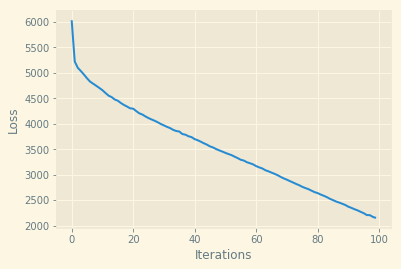

In [83]:
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(range(loss.__len__()), loss)


In [ ]:
parallel_evaluation_loop(encoder, decoder, dictionary`)